In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [2]:
def resumen(datos):
    return print('Forma:\n', datos.shape,'\n\n',
                 'Columnas:\n', datos.columns,'\n\n',
                 'Tipos:\n', datos.dtypes,'\n\n',
                 'Datos nulos:\n', datos.isnull().sum(),'\n\n',
                 'Cabecera:\n', datos.head(10),'\n\n',
                 'Últimos datos:\n', datos.tail(10),'\n\n',
                 'Estadísticos:\n', datos.describe([0.05,0.25,0.5,0.75,0.95])
                )
def truncar(numero, decimales = 0):
    return np.trunc(numero*10**decimales)/(10**decimales)

In [108]:
def lineal(x, a, b):
    linea = a*x + b
    return linea

def spielman(t_rg, alfa, beta, ref):
    # Poner t y tref en centigrados
    t0 = 267
    tref = 10
    t = t_rg[:,0]
    rg = t_rg[:,1]
    nee = (-(alfa*beta*rg) / (alfa*rg + beta)
            + ref * np.exp(
                e0/(tref+273.16-t0)
                - e0/(t+273.16-t0)
            )
           )
    return nee
def wolfahrt(ta_ts, porc, ref_a, ref_s, e0):
    # Poner t y tref en centigrados
    tref = 10
    ta = ta_ts[:,0]
    ts = ta_ts[:,1]
    nee = (porc * ref_a*np.exp(e0*(ta-tref))
           + (1-porc) * ref_s*np.exp(e0*(ts-tref))
          )
    return nee
def wolfahrt_1(ta_ts, ref_a, ref_s, e0):
    # Poner t y tref en centigrados
    tref = 10
    ta = ta_ts[:,0]
    ts = ta_ts[:,1]
    nee = (ref_a*np.exp(e0*(ta-tref))
           + ref_s*np.exp(e0*(ts-tref))
          )
    return nee
def wolfahrt_2(ta_ts_p, ref_a, ref_s, e0):
    # Poner t y tref en centigrados
    tref = 10
    ta = ta_ts_p[0][:,0]
    ts = ta_ts_p[0][:,1]
    porc = ta_ts_p[1]
    nee = (porc * ref_a*np.exp(e0*(ta-tref))
           + (1-porc) * ref_s*np.exp(e0*(ts-tref))
          )
    return nee

In [4]:
def coef_determinacion(observaciones, predicciones):
    residuo = observaciones - predicciones
    ss_res = np.sum(residuo**2)
    ss_tot = np.sum((observaciones - np.mean(observaciones))**2)
    r_cuadrado = 1 - (ss_res/ss_tot)
    return r_cuadrado
def regresion(modelo, x, y, inicial = [1,1], pesos = None):
    # No puede haber nungún NaN
    ajuste, covarianzas = curve_fit(f = modelo,
                                    xdata = x,
                                    ydata = y,
                                    #sigma = pesos,
                                    p0 = inicial
                                   )
    predicciones = modelo(x, *ajuste)
    errores = np.sqrt(np.diag(covarianzas))
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    return predicciones, ajuste, errores, r_cuadrado, residuo

In [5]:
def metadata(ejex, ejey):
    # plt.title(titulo, fontsize = 60, fontweight='bold')
    plt.xlabel(ejex, fontsize = 35)
    plt.ylabel(ejey, fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return
def cifras_signif(i, cifras):
    texto = str('{:g}'.format(float('{:.{p}g}'.format(i, p = cifras))))
    return texto
def grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuad, nombres,
                   j = 3
                  ):
    etiqueta = ''
    iterador = list(range(len(nombres)))
    for i in iterador:
        valor = cifras_signif(ajuste[i], j)
        error = cifras_signif(errores[i], j)
        etiqueta = (etiqueta
                    + ' ' + nombres[i] + ' = ' + valor
                    + '; std ' + nombres[i] + ' = ' + error
                    + '\n')
    etiqueta = etiqueta + ' $R^2$ = ' + cifras_signif(r_cuad, j)
    plt.plot(x, y, 'bo', markersize = 2)
    plt.plot(x, predicciones, 'r-',
             label = etiqueta
             )
    plt.legend(fontsize = 20)
    return

In [6]:
def validar(metodo, ajuste, validacion_x, validacion_y, lab, nombres):
    pred = metodo(validacion_x.values,
                  *ajuste
                  )
    recta, var, errores, r_cuadrado, res = regresion(lineal,
                                                     validacion_y,
                                                     pred
                                                     )
    plt.figure(figsize = (18, 9))
    grafico_modelo(validacion_y, pred, recta,
                   var, errores, r_cuadrado,
                   nombres
                  )
    metadata(lab + ' Obs', lab + ' Pred')
    extremos = [validacion_y.min(), validacion_y.max()]
    plt.plot(extremos, extremos, 'g--')
    return pred, r_cuadrado, var, errores

In [8]:
datos = pd.read_csv(
    #'C:\\Users\\nahue\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    delimiter = '\t',
    decimal = '.',
    na_values = -9999,
    skiprows = [1],
    encoding = 'ascii'
    )

In [9]:
resumen(datos)

Forma:
 (14956, 38) 

 Columnas:
 Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar', 'TS1', 'TS2', 'TS3', 'TS4', 'U', 'DIR', 'PP', 'QG1',
       'QG2', 'WET', 'PAR', 'TSH1', 'HS1', 'GH1', 'TSH2', 'HS2', 'GH2', 'TSH3',
       'HS3', 'GH3', 'TSH4', 'HS4', 'GH4', 'PAR.1', '   r_err_co2[%]',
       '   noise_co2[%]'],
      dtype='object') 

 Tipos:
 Year               float64
DoY                float64
Hour               float64
NEE                float64
LE                 float64
H                  float64
Rg                 float64
Tair               float64
Tsoil              float64
rH                 float64
VPD                float64
Ustar              float64
TS1                float64
TS2                float64
TS3                float64
TS4                float64
U                  float64
DIR                float64
PP                 float64
QG1                float64
QG2                float64
WET                float64
PAR     

In [10]:
datos['Error porcent'] = datos['   r_err_co2[%]'] + datos['   noise_co2[%]']
datos['Error'] = abs(datos['Error porcent']/100 * datos['NEE'])

In [11]:
datos_diurnos = datos[(datos['Rg'] >= 5)
                      & (datos['Ustar'] > 0.14167)
                      & (datos['PAR.1'] > 1)
                      & pd.notna(datos['NEE'])
                      & (datos['Error porcent'] < 30)
                      #& (datos['Error'] < 0.5)
                     ]
datos_diurnos.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,HS3,GH3,TSH4,HS4,GH4,PAR.1,r_err_co2[%],noise_co2[%],Error porcent,Error
count,3428.0,3428.000000,3428.000000,3428.000000,3399.000000,3402.000000,3428.000000,3428.000000,3428.000000,3428.000000,...,3138.000000,3138.000000,3233.000000,3233.000000,3233.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000
mean,2018.0,266.954492,13.103121,-3.418176,116.730619,125.694120,441.700308,15.795051,12.973970,62.177897,...,0.534242,0.212203,12.704182,0.399682,0.296581,819.217154,11.659976,0.938211,12.598187,0.427237
std,0.0,61.333363,3.307610,3.356549,88.427451,119.771604,298.375613,5.449616,4.219740,15.736072,...,0.031814,0.025817,3.036121,0.040408,0.037152,534.261431,3.713431,0.762902,3.978988,0.337967
min,2018.0,91.000000,0.125000,-21.042500,-187.969055,-86.813431,5.005000,-0.645000,2.772500,19.600000,...,0.444500,0.148000,7.200000,0.200000,0.167500,1.030000,5.981359,0.084813,7.034158,0.000247
1%,2018.0,95.000000,6.125000,-14.870246,-11.942811,-49.606118,7.889850,4.795500,4.484725,27.506050,...,0.454185,0.167000,7.400000,0.235000,0.172000,15.342550,7.132718,0.203161,8.059399,0.012354
10%,2018.0,174.000000,8.625000,-7.471940,19.287605,-13.223467,62.503500,9.547000,7.370000,41.129500,...,0.469350,0.175000,8.881000,0.347500,0.244000,117.170000,8.250884,0.399037,9.158013,0.096049
25%,2018.0,229.000000,10.625000,-5.061863,51.025356,28.835639,196.162500,11.767500,9.356875,51.406250,...,0.539500,0.194000,10.055000,0.378500,0.277500,373.937500,9.224265,0.577823,10.033732,0.184579
50%,2018.0,277.000000,13.125000,-2.854175,97.094013,102.024967,401.051136,15.237500,12.942500,62.750000,...,0.546000,0.212000,12.400000,0.406500,0.308000,770.475000,10.658099,0.783681,11.392244,0.349516
75%,2018.0,318.000000,15.625000,-1.306263,166.777548,207.065050,657.150000,19.041250,16.278750,73.805000,...,0.551000,0.229000,15.395000,0.426500,0.319500,1222.500000,12.801223,1.005035,13.648502,0.574139
90%,2018.0,340.000000,17.625000,0.165320,243.819806,297.734886,898.500000,23.395000,18.609000,83.200000,...,0.558000,0.249500,16.800000,0.445000,0.339000,1608.800000,16.497556,1.458121,17.664688,0.839963


In [12]:
muestra = datos_diurnos.sample(frac = 4/5, random_state = 1)
validacion = datos_diurnos.drop(muestra.index)

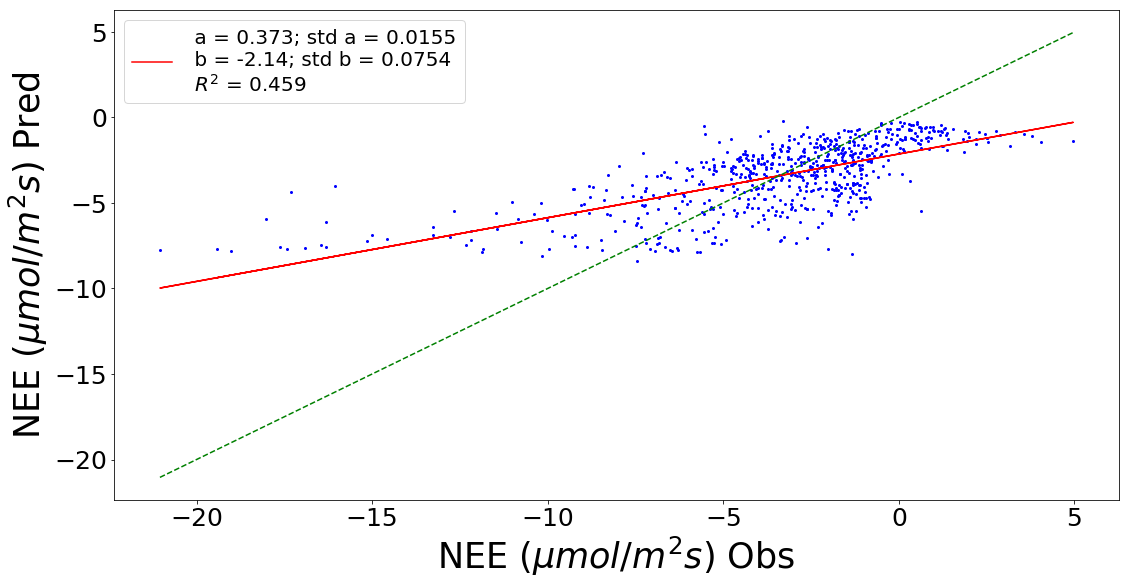

In [58]:
temperatura = 'Tsoil'
#Tair e0 = 36.2
e0 = 49.5
desde = 0
hasta = 370
t_rg = muestra[(muestra['DoY'] < hasta)
               & (muestra['DoY'] > desde)
              ][[temperatura, 'PAR.1']].values
nee = muestra[(muestra['DoY'] < hasta)
              & (muestra['DoY'] > desde)
             ]['NEE'].values
reg = regresion(spielman,
                t_rg,
                nee,
                inicial = [0.01,
                           6,
                           1,
                          ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg
val_x = validacion[(validacion['DoY'] < hasta)
                  & (validacion['DoY'] > desde)
                  ][[temperatura, 'PAR.1']]
val_y = validacion[(validacion['DoY'] < hasta)
                  & (validacion['DoY'] > desde)
                  ]['NEE']
val_final = validar(spielman, ajuste, val_x,
                    val_y, 'NEE ($\\mu mol/m^2 s$)',
                    ['a', 'b']
                   )
#plt.savefig('C:\\Users\\nahue\\Desktop\\Anual_' + temperatura + '.png')

In [59]:
ajuste

array([ 3.48898173e-03,  1.27899305e+03, -3.87298520e-01])

In [60]:
r_cuadrado

0.42766083186444426

In [32]:
dias = np.arange(60, 420, 60)
ajustes = list(range(1, len(dias)))
r_cuadr = list(range(1, len(dias)))
resp = list(range(1, len(dias)))
diff = list(range(len(resp)))
#Tair e0_bim = [42.90, 8.24, 5.52, 22.99, 19.79]
#Tair llyt_bim = [1.66, 1.10, 0.92, 1.44, 1.96]
e0_bim = [23.78, 31.08, 40.49, 29.63, 42.84]
llyt_bim = [2.12, 1.09, 1.08, 1.22, 1.17]
for i in list(range(1, len(dias))):
    desde = dias[i-1]
    hasta = dias[i]
    muestra_vent = muestra[(muestra['DoY'] > desde)
                           & (muestra['DoY'] < hasta)
                           ]
    validacion_vent = validacion[(validacion['DoY'] > desde)
                                 & (validacion['DoY'] < hasta)
                                 ]
    t_rg = muestra_vent[[temperatura, 'PAR.1']].values
    nee = muestra_vent['NEE'].values
    e0 = e0_bim[i-1]
    reg = regresion(spielman,
                    t_rg,
                    nee,
                    inicial = [0.01,
                               6,
                               1
                              ],
                    pesos = None
                    )
    predicciones, ajustes[i-1], errores, r_cuadr[i-1], residuo = reg
    val_x = validacion_vent[[temperatura, 'PAR.1']]
    val_y = validacion_vent['NEE']
    val_final = validar(spielman, ajuste, val_x,
                        val_y, 'NEE ($\\mu mol/m^2 s$)',
                        ['a', 'b']
                       )
    resp[i-1] = ajustes[i-1][2]
    diff[i-1] = 100*(llyt_bim[i-1]-resp[i-1]) / llyt_bim[i-1]
    plt.savefig('C:\\Users\\nahue\\Desktop\\'
                + temperatura + ' '
                + str(desde) + '_' + str(hasta)
                + '.png'
               )
    plt.close()

In [33]:
r_cuadr

[0.33412018115684594,
 0.47830477029516927,
 0.2668018600681282,
 0.41219322757601673,
 0.5380495854448095]

In [34]:
resp

[-0.5649389535708595,
 0.1330479476541902,
 0.9369906573127315,
 1.0190603394981415,
 1.1056286274666047]

In [35]:
diff

[126.64806384768204,
 87.79376627025779,
 13.241605804376722,
 16.470463975562176,
 5.501826712256]

In [18]:
datos_nocturnos = datos[(datos['Rg'] < 5)
                      & (datos['Ustar'] > 0.14167)
                      & (datos['NEE'] >= 0)
                      & pd.notna(datos['NEE'])
                      & (datos['Error porcent'] < 40)
                      & (datos['Error'] < 0.5)
                     ]
datos_nocturnos.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,HS3,GH3,TSH4,HS4,GH4,PAR.1,r_err_co2[%],noise_co2[%],Error porcent,Error
count,1969.0,1969.000000,1969.000000,1969.000000,1932.000000,1969.000000,1.969000e+03,1969.000000,1969.000000,1969.000000,...,1826.000000,1826.000000,1890.000000,1890.000000,1890.000000,1.969000e+03,1969.000000,1969.000000,1969.000000,1969.000000
mean,2018.0,251.303200,11.873857,1.469603,8.264845,-34.474098,1.538725e-01,11.171673,11.475249,79.523591,...,0.538907,0.208666,12.279352,0.407265,0.288875,4.055655e+00,11.879181,0.981185,12.860366,0.180274
std,0.0,62.158416,9.159219,1.030998,17.302130,16.854650,6.022061e-01,4.367227,3.503864,9.089521,...,0.028404,0.026230,2.979379,0.034179,0.038203,8.160388e+00,4.010771,1.015984,4.354245,0.122271
min,2018.0,91.000000,0.125000,0.000450,-111.854263,-138.818542,1.808498e-12,-1.005000,4.187500,43.250000,...,0.447000,0.148000,7.330000,0.233500,0.111000,1.831424e-12,5.653092,0.135974,6.510600,0.000038
1%,2018.0,95.000000,0.125000,0.035334,-19.152808,-80.797717,4.561684e-12,1.791400,4.950200,54.897600,...,0.460500,0.149000,7.400000,0.330780,0.171000,2.053469e-12,7.384755,0.348321,8.288419,0.004083
10%,2018.0,169.000000,1.125000,0.312110,-8.813742,-56.918958,1.500000e-02,5.708000,7.339000,66.344000,...,0.471500,0.174000,8.800000,0.354000,0.241000,7.000000e-02,8.653820,0.480785,9.475563,0.038023
25%,2018.0,209.000000,3.125000,0.680750,-2.783787,-44.902908,2.000000e-02,8.525000,8.467500,74.130000,...,0.541125,0.186000,9.581250,0.391000,0.272500,2.050000e-01,9.533945,0.574025,10.288041,0.083982
50%,2018.0,256.000000,7.125000,1.257850,4.975692,-32.371974,2.500000e-02,10.845000,11.152500,81.200000,...,0.547500,0.208500,12.100000,0.411500,0.291000,1.080000e+00,10.822520,0.725782,11.614039,0.155692
75%,2018.0,301.000000,21.125000,2.064400,15.633125,-22.550114,3.000000e-02,13.760000,14.182500,86.700000,...,0.553000,0.227000,14.955000,0.430875,0.313000,4.085000e+00,12.739927,0.974556,13.748337,0.261880
90%,2018.0,327.000000,22.625000,2.974590,29.124749,-15.128374,5.000000e-02,17.061000,16.508000,89.900000,...,0.559500,0.247000,16.795500,0.448550,0.336000,1.001000e+01,16.208500,1.541331,17.449468,0.370366


In [109]:
ta_ts = datos_nocturnos[['Tair', 'Tsoil']].values
nee_n = datos_nocturnos['NEE'].values
reg = regresion(wolfahrt_1,
                ta_ts,
                nee_n,
                inicial = [1,
                           1,
                           0.1,
                          ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg

In [110]:
r_cuadrado

0.44802560311804873

In [111]:
ajuste # Suma de modelos con ta y ts

array([-0.06015079,  1.19133514,  0.12106818])

In [112]:
reg = regresion(wolfahrt,
                ta_ts,
                nee_n,
                inicial = [0.2,
                           1,
                           1,
                           0.1
                           ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg

In [113]:
r_cuadrado

0.4480256030613372

In [114]:
ajuste # Suma de modelos con ta y ts pesada libre

array([-0.11993559,  0.50139391,  1.06374727,  0.12106675])

In [115]:
porcent = np.arange(0.1, 1, 0.1)
r2 = list(range(len(porcent)))
ref_a = list(range(len(porcent)))
ref_s = list(range(len(porcent)))
e0 = list(range(len(porcent)))
for i in range(len(porcent)):
    ta_ts_p = [ta_ts , porcent[i]]
    reg = regresion(wolfahrt_2,
                    ta_ts_p,
                    nee_n,
                    inicial = [1,
                               1,
                               0.01
                              ],
                    pesos = None
                    )
    predicciones, ajuste, errores, r_cuadrado, residuo = reg
    r2[i] = round(r_cuadrado, 4)
    ref_a[i] = round(ajuste[0], 4)
    ref_s[i] = round(ajuste[1], 4)
    e0[i] = round(ajuste[2], 4)

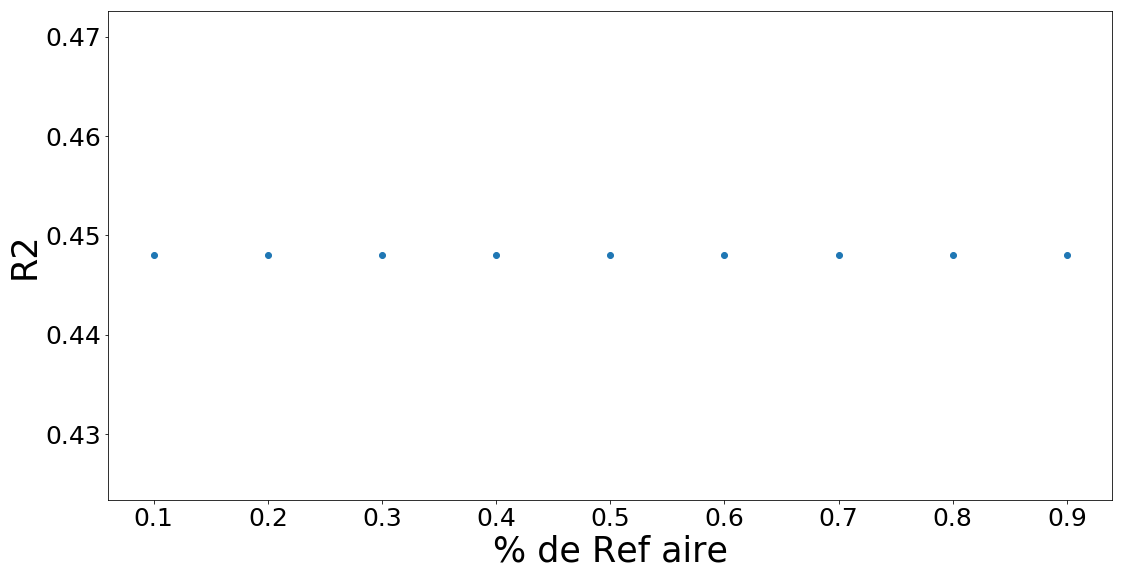

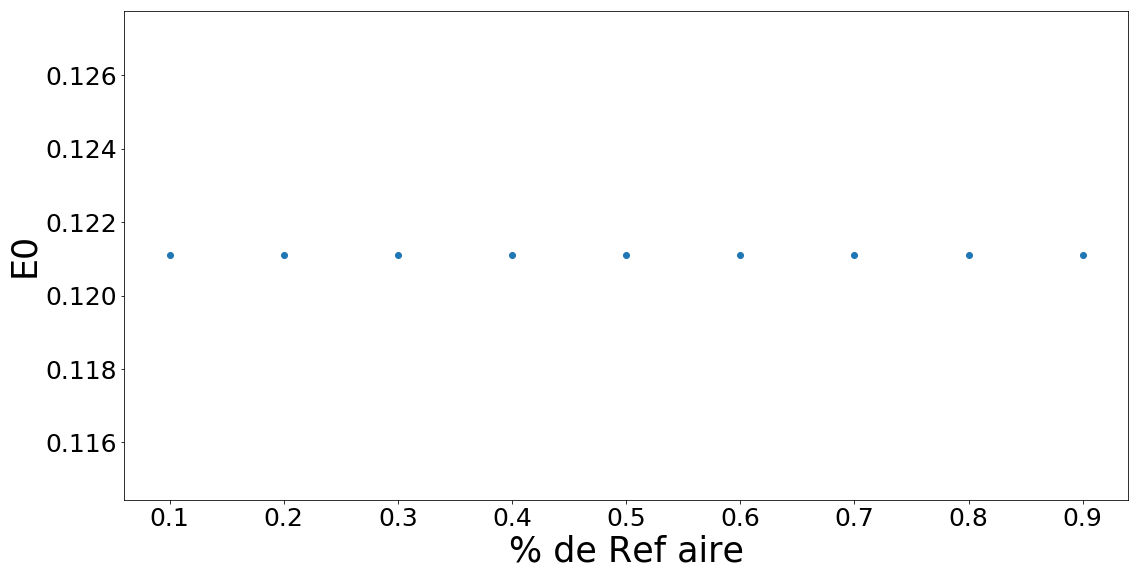

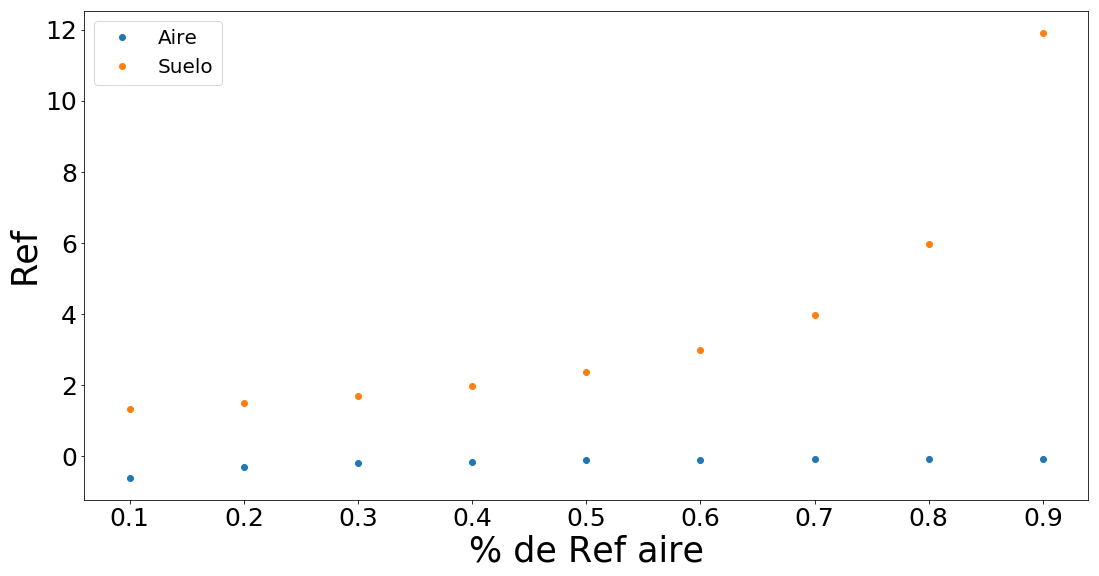

In [116]:
plt.figure(figsize = (18, 9))
plt.plot(porcent, r2, 'o')
metadata('% de Ref aire', 'R2')

plt.figure(figsize = (18, 9))
plt.plot(porcent, e0, 'o')
metadata('% de Ref aire', 'E0')

plt.figure(figsize = (18, 9))
plt.plot(porcent, ref_a, 'o')
plt.plot(porcent, ref_s, 'o')
metadata('% de Ref aire', 'Ref')
plt.legend(['Aire', 'Suelo'], fontsize = 20)

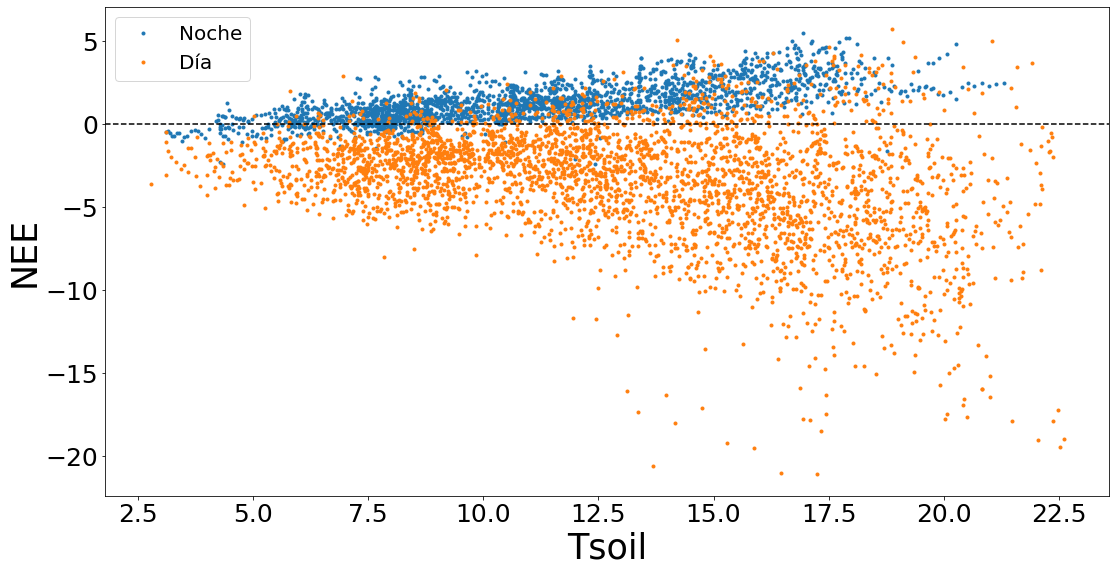

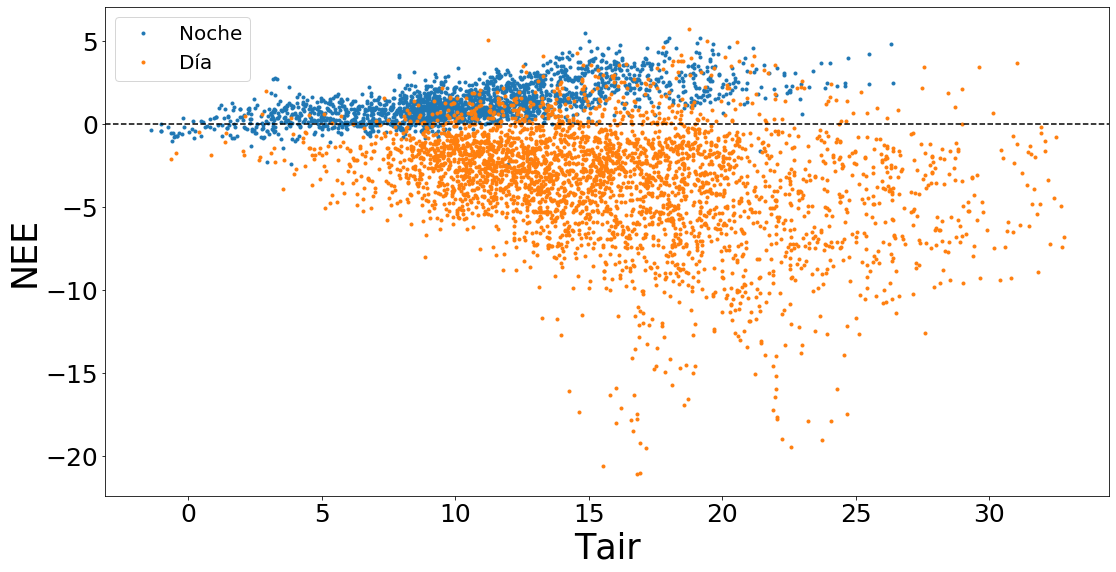

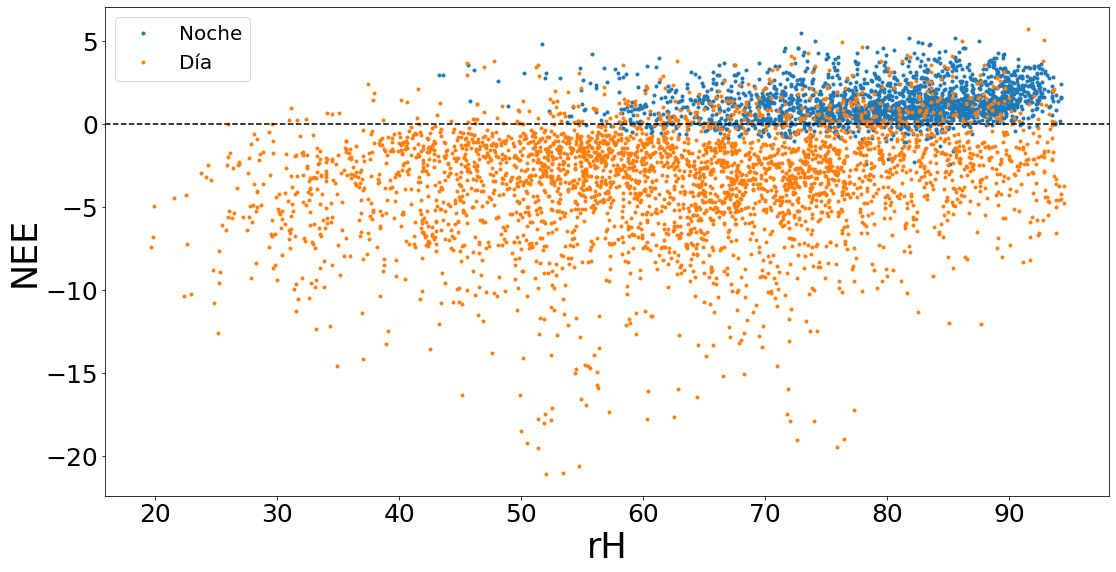

In [23]:
dn = datos[(datos['Rg'] < 5)
          & (datos['Ustar'] > 0.14167)
          & (datos['Error porcent'] < 40)
          & (datos['Error'] < 0.5)
          ]
dd = datos[(datos['Rg'] >= 5)
          & (datos['Error porcent'] < 30)
          & (datos['Ustar'] > 0.14167)
          ]
variable = ['Tsoil', 'Tair', 'rH']
for i in variable:
    plt.figure(figsize = (18, 9))
    metadata(i, 'NEE')
    plt.plot(dn[i], dn['NEE'], 'o', ms = 3)
    plt.plot(dd[i], dd['NEE'], 'o', ms = 3)
    plt.axhline(0, ls = '--', color = 'black')
    plt.legend(['Noche', 'Día'], fontsize = 20)
    plt.savefig('C:\\Users\\nahue\\Desktop\\' + i + '.png')